In [1]:
import gzip
import csv
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import libpysal
import segregation
import mapclassify
from segregation.local import MultiLocationQuotient, MultiLocalDiversity, MultiLocalEntropy, MultiLocalSimpsonInteraction, MultiLocalSimpsonConcentration, LocalRelativeCentralization

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#read lodes data
lehd_df = pd.read_csv('data\lodes\ca_wac_S000_JT00_2017.csv.gz',compression='gzip',header=0,sep=',',quotechar='"',error_bad_lines=False)
#convert w_geocode to string to make it easier to check
lehd_df['w_geocode'] = lehd_df['w_geocode'].astype(str)
# check if beginning of string matches SD county fips code
lehd_df = lehd_df[lehd_df['w_geocode'].str.match('6073')]
#add leading 0 to make consistent with block data(below)
#SDlehd_df.iloc[] = '0' + SDlehd_df.loc['w_geocode']
lehd_df['w_geocode'] = '0' + lehd_df['w_geocode']

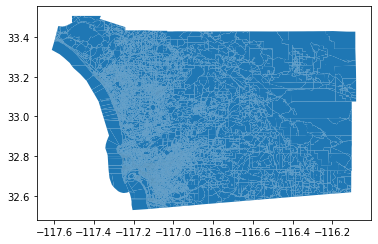

In [3]:
# Lets get the shp data ready to be linked to the LODES data
sd_blocks = gpd.read_file('data\\blocks\\sd\\tl_2010_06073_tabblock10.shp')
sd_blocks.plot()

In [4]:
# rename column for join
lehd_df.rename(columns={'w_geocode': 'GEOID10'}, inplace=True)
# merge geodataframe and dataframe on common variable
SDlehd_blocks = sd_blocks.merge(lehd_df, how='left', on='GEOID10')

In [5]:
#Get rid of many unneeded columns/rows
SDlehd_blocks.drop(['INTPTLON10','INTPTLAT10','COUNTYFP10','STATEFP10','NAME10','TRACTCE10','BLOCKCE10','MTFCC10','FUNCSTAT10','UR10','AWATER10','UACE10','UATYP10','createdate'], axis=1, inplace=True)
SDlehd_blocks.fillna(0,inplace=True)
#Remove any blocks where there is no land area, no jobs there so why would we care about them?
SDlehd_blocks = SDlehd_blocks[SDlehd_blocks.ALAND10 != 0]

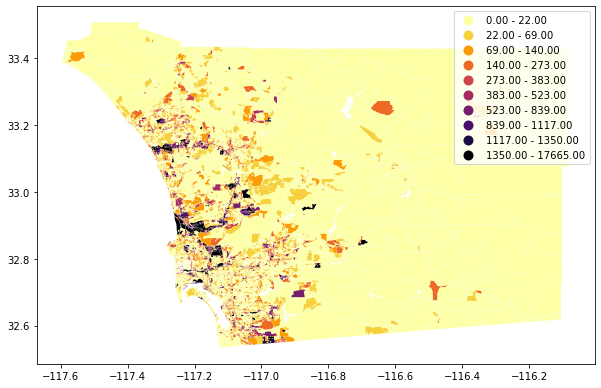

In [6]:
SDlehd_blocks.plot(column='C000', cmap='inferno_r', k=10, scheme='fisherjenkssampled', figsize = (10,10), legend=True)

In [7]:
#create lists of related categories to refer to later
df_columns = SDlehd_blocks.columns.tolist()
workerage_list = df_columns[4:7]
workerwage_list = df_columns[7:10]
jobs_list = df_columns[10:30]
race_list = df_columns[30:38]
edu_list= df_columns[38:42]
sex_list = df_columns[42:44]
firmage_list = df_columns[44:49]
firmsize_list = df_columns[49:54]

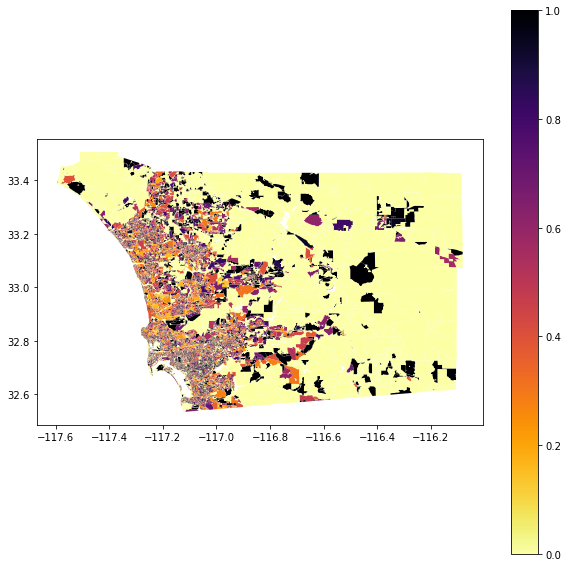

In [8]:
JobsSimpsonIndex = MultiLocalSimpsonConcentration(SDlehd_blocks, jobs_list)
SDlehd_blocks['Job_Local_Simpson_Concentration'] = JobsSimpsonIndex.statistics
SDlehd_blocks.plot(column='Job_Local_Simpson_Concentration', cmap='inferno_r', figsize = (10,10), legend=True)

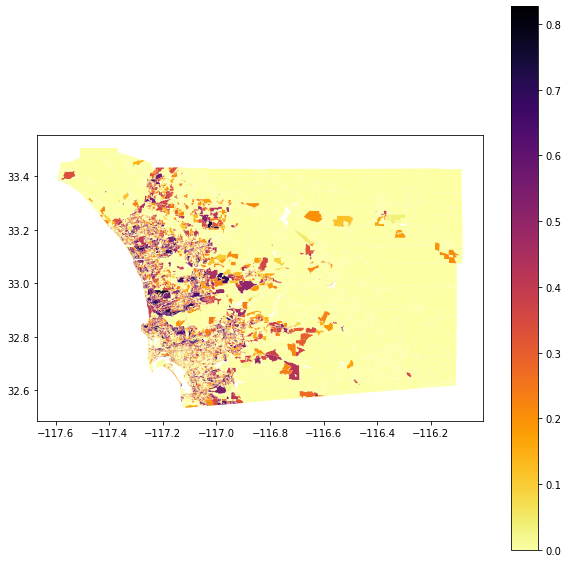

In [9]:
JobLocalEntropyIndex = MultiLocalEntropy(SDlehd_blocks, jobs_list)
SDlehd_blocks['Job_Local_Entropy'] = JobLocalEntropyIndex.statistics
SDlehd_blocks.plot(column='Job_Local_Entropy', cmap='inferno_r', figsize = (10,10), legend=True)

## Location Quotient

In [10]:
"""
#nested list for LQ for loop
lehd_lists = [workerage_list,workerwage_list,jobs_list,race_list,edu_list,sex_list,firmage_list,firmsize_list]
index_list = WorkerAgeLQIndex, WorkerWageLQIndex, JobsLQIndex, RaceLQIndex, EduLQIndex, SexLQIndex, FirmAgeLQIndex,FirmSizeLQIndex
for_list =  zip(lehd_lists,index_list)

for lehd_lists,index_lists in for_list:
    for items in for_list:
        items = MultiLocationQuotient(SDlehd_blocks, lehd_lists[lehd_lists])
        SDlehd_blocks['LQ_' + lehd_list[lehd_lists]] = items.statistics[:,lehd_lists]
"""


WorkerAgeLQIndex = MultiLocationQuotient(SDlehd_blocks, workerage_list)
WorkerWageLQIndex = MultiLocationQuotient(SDlehd_blocks, workerwage_list)
JobsLQIndex = MultiLocationQuotient(SDlehd_blocks, jobs_list)
RaceLQIndex = MultiLocationQuotient(SDlehd_blocks, race_list)
EduLQIndex = MultiLocationQuotient(SDlehd_blocks, edu_list)
SexLQIndex = MultiLocationQuotient(SDlehd_blocks, sex_list)
FirmAgeLQIndex = MultiLocationQuotient(SDlehd_blocks, firmage_list)
FirmSizeLQIndex = MultiLocationQuotient(SDlehd_blocks, firmsize_list)


for items in range(len(workerage_list)):
    SDlehd_blocks['LQ_' + workerage_list[items]] = WorkerWageLQIndex.statistics[:,items]

for items in range(len(workerwage_list)):
    SDlehd_blocks['LQ_' + workerwage_list[items]] = WorkerWageLQIndex.statistics[:,items]

for items in range(len(jobs_list)):
    SDlehd_blocks['LQ_' + jobs_list[items]] = JobsLQIndex.statistics[:,items]

for items in range(len(race_list)):
    SDlehd_blocks['LQ_' + race_list[items]] = RaceLQIndex.statistics[:,items]
    
for items in range(len(edu_list)):
    SDlehd_blocks['LQ_' + edu_list[items]] = EduLQIndex.statistics[:,items]
    
for items in range(len(sex_list)):
    SDlehd_blocks['LQ_' + sex_list[items]] = SexLQIndex.statistics[:,items]
    
for items in range(len(firmage_list)):
    SDlehd_blocks['LQ_' + firmage_list[items]] = FirmAgeLQIndex.statistics[:,items]
    
for items in range(len(firmsize_list)):
    SDlehd_blocks['LQ_' + firmsize_list[items]] = FirmSizeLQIndex.statistics[:,items]

In [11]:
#Create a cmap that's more appropriate for displaying LQ
from pysal.viz.splot._viz_utils import shift_colormap
lqmap = shift_colormap('YlOrBr', midpoint=1.0)
#Remove 0 in LQ; more buckets for other values
col_list = SDlehd_blocks.columns.tolist()
lqlist = [lq for lq in col_list if 'LQ_' in lq]
for lq in lqlist:
    SDlehd_blocks[lq].replace(0,'NaN')

C:\Users\test\anaconda3\envs\rec\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [12]:
#ALL_LQ = gpd.GeoDataFrame(columns=['LQ'])
#for lqs in range(len(lqlist)):
#    = ALL_LQ['LQ'].append(SDlehd_blocks[lqlist[lqs]])

#ALL_LQ['LQ'].append(SDlehd_blocks['LQ_CA01'])
#ALL_LQ['LQ']
#ud = mapclassify.UserDefined(SDlehd_blocks['LQ_CD04'],bins = [.2, 10, 55])
#ud.bins

In [13]:
def graph_codes(code,cmap='OrRd',k=5):
    """A function that takes the LEHD code(string), cmap(string), and k(int) as arguements. Graphs both the original
   and the LQ of the code with arguements specified. Default scheme is FisherJenksSampled. Can I add error handling for when
   not enough unique values for requested value of k?"""
    fig, axs = matplotlib.pyplot.subplots(1,2, figsize=(20,10))
    axs[0].set_title(code)
    axs[1].set_title('LQ_'+ code)
    SDlehd_blocks.plot(column= code, cmap=cmap, k=k, scheme='fisherjenkssampled', figsize = (10,10), legend=True, ax=axs[0])
    SDlehd_blocks.plot(column= 'LQ_' + code, cmap=lqmap, k=k, scheme='fisherjenkssampled', figsize = (10,10), legend=True, ax=axs[1])

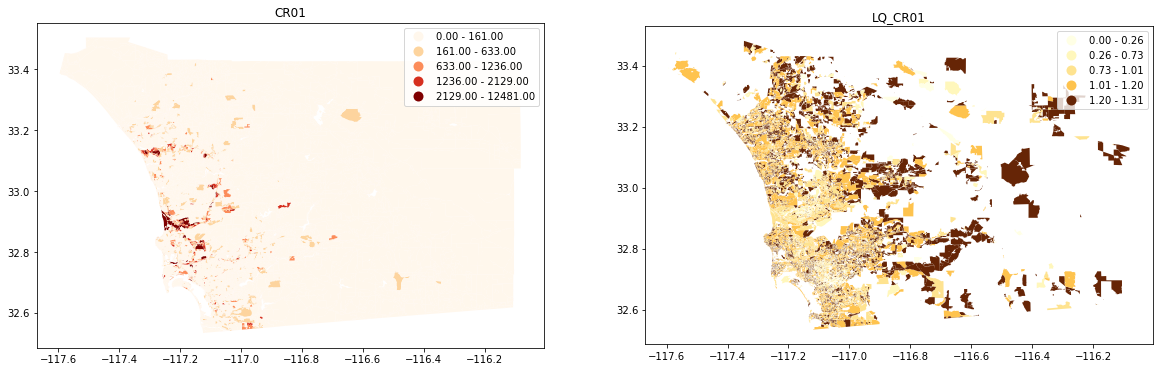

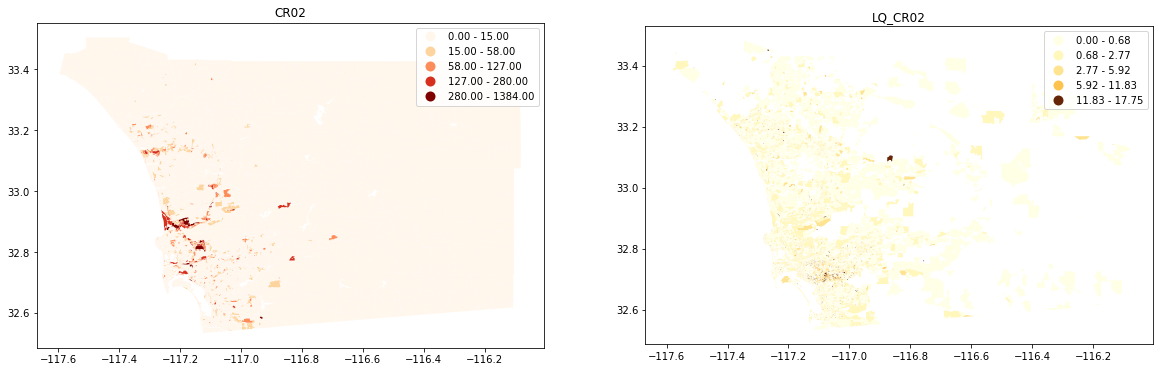

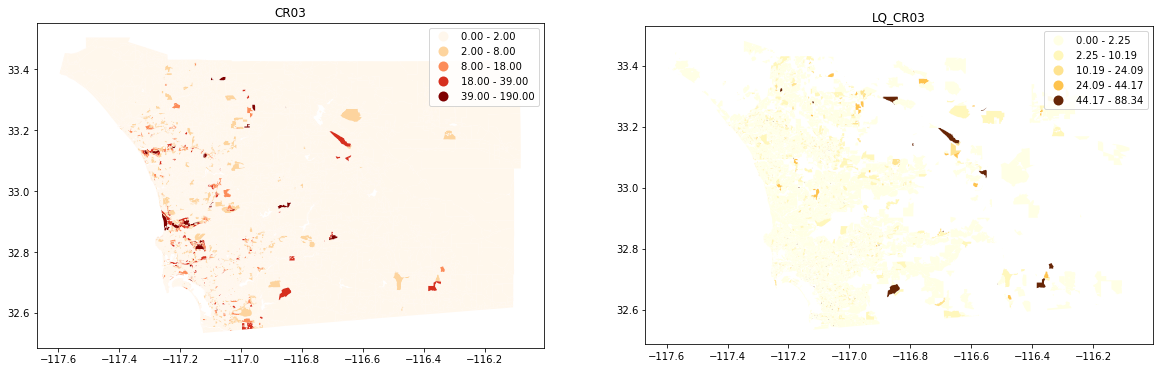

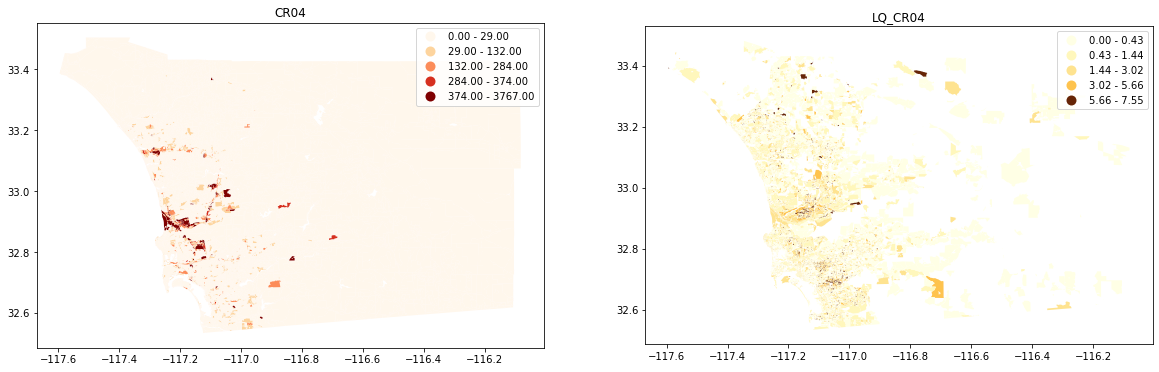

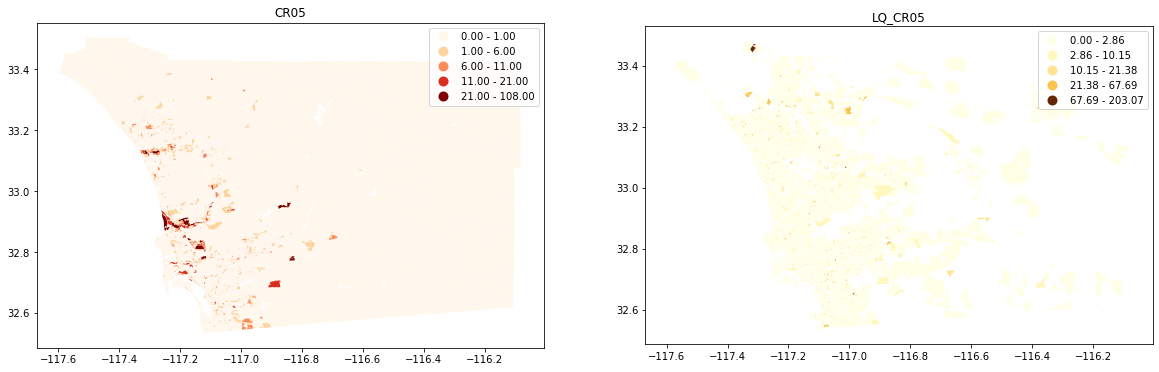

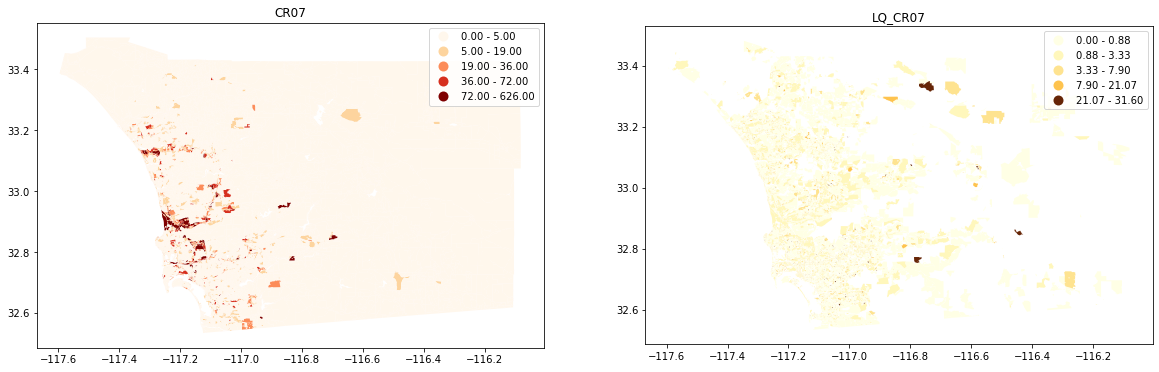

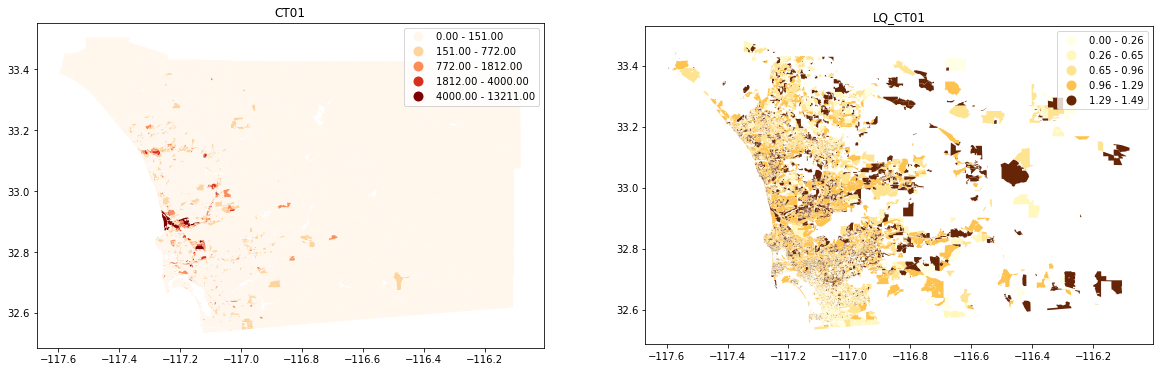

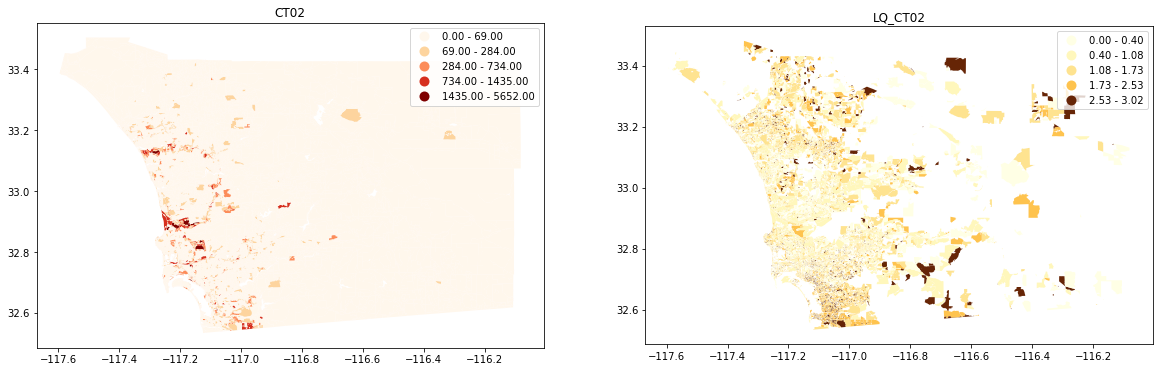

In [14]:
for codes in race_list:
    graph_codes(codes,'OrRd',5)

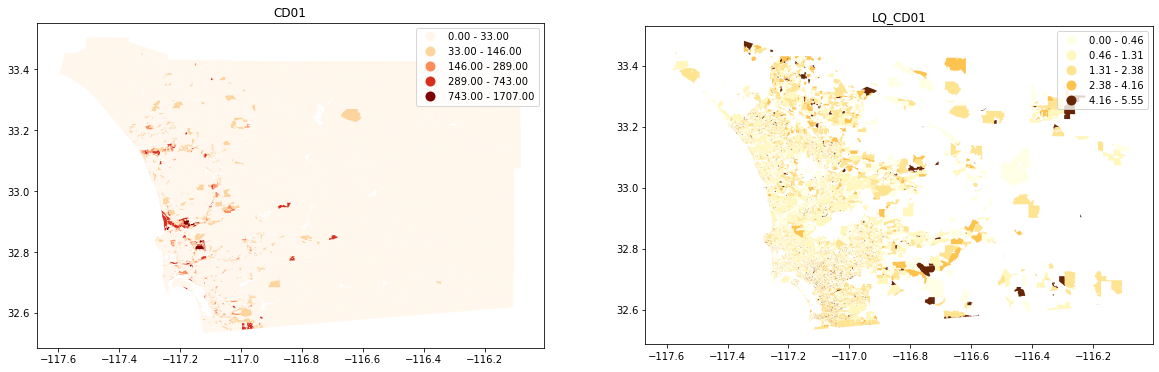

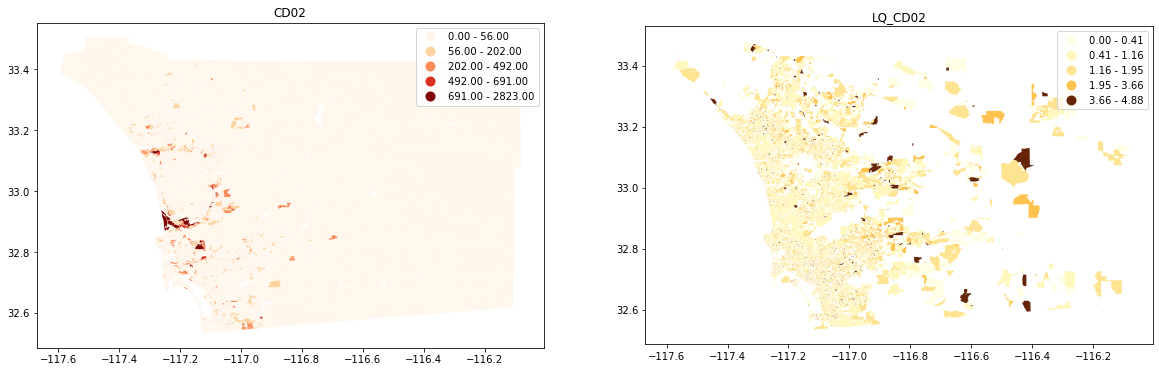

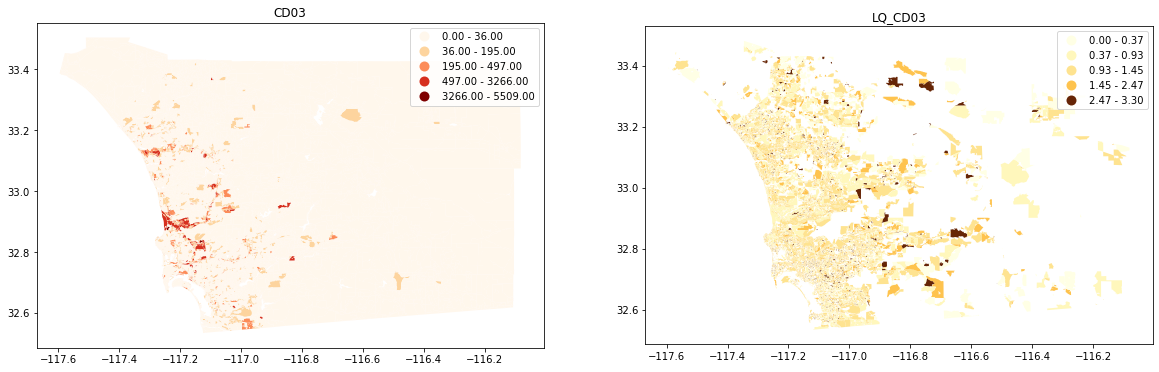

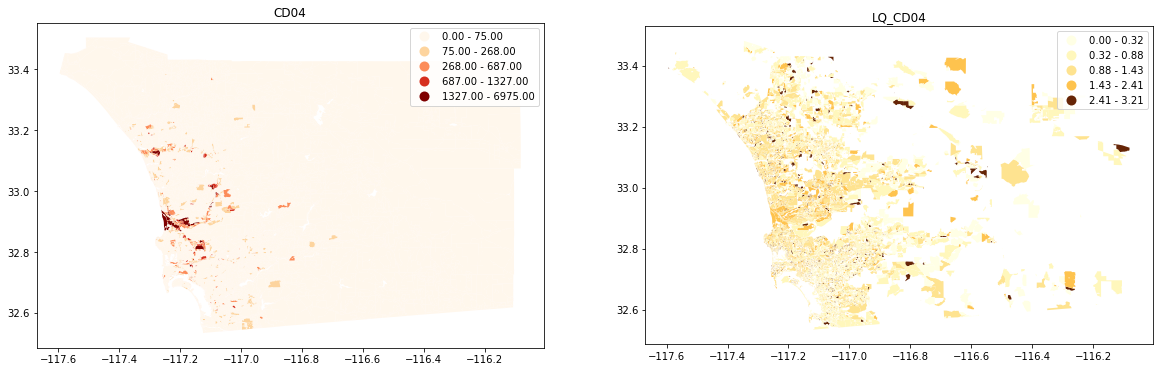

In [15]:
for codes in edu_list:
    graph_codes(codes)

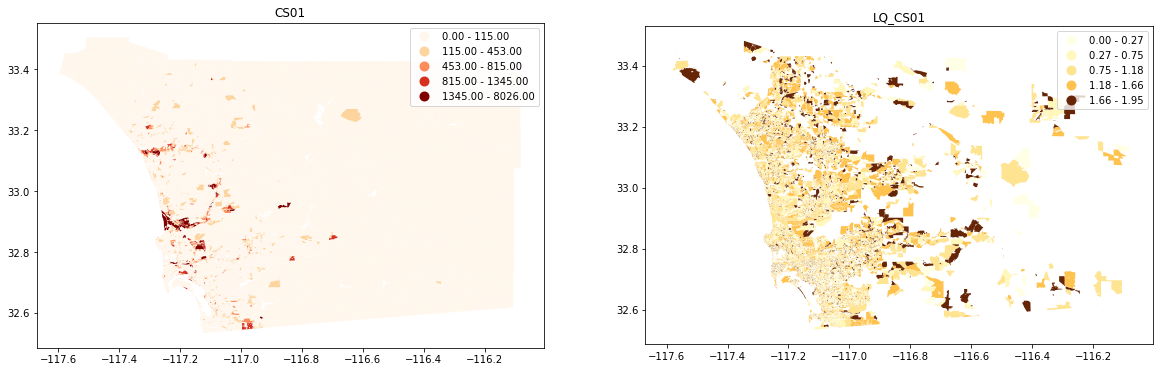

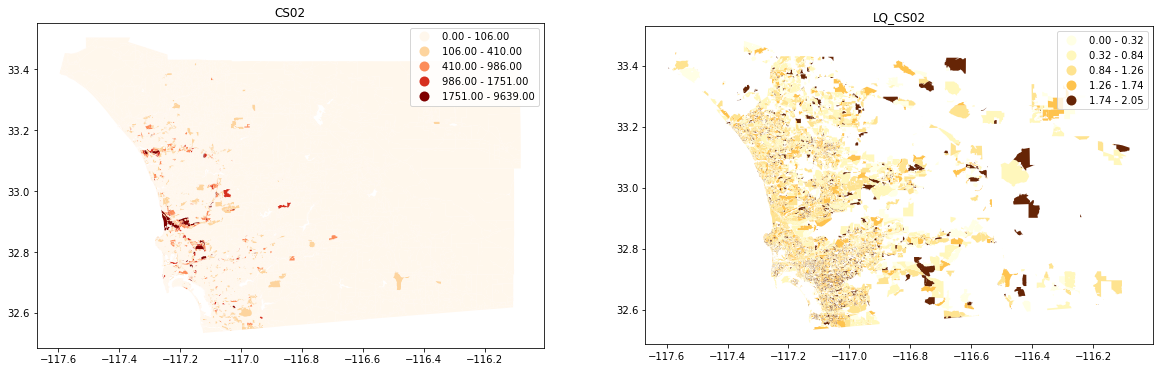

In [16]:
for codes in sex_list:
    graph_codes(codes)